In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from scipy.stats import linregress
import os
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn import linear_model

#output_data_file = "output_data/.csv"

**1. Importing/Cleaning Data**

In [41]:
data_file = "Resources/life_expectancy_data_region.csv"
life_df = pd.read_csv(data_file)

#trim the dataframe to the columns that we need
life_df = life_df[["Country", "Year", "Region", "Status", "Life expectancy ", "Adult Mortality", "Alcohol", 
                   "percentage expenditure", "Hepatitis B", "Measles ", " BMI ", "Polio", "Total expenditure",
                  "Diphtheria ", " HIV/AIDS", "under-five deaths ", "GDP", "Population", "Schooling"]]


life_df = life_df.rename(columns={'Life expectancy ': 'Life Expectancy', 
                        'percentage expenditure': 'Percentage Expenditure',
                        'Measles ': 'Measles',
                        ' BMI ': 'BMI',
                        "Total expenditure": "Total Expenditure",
                        "Diphtheria ": "Diphtheria",
                        " HIV/AIDS": "HIV/AIDS",
                        "under-five deaths ": "Under Five Deaths"
                        })

HIV_percent = (life_df['HIV/AIDS']/life_df['Population']) * 1000
measle_percent = (life_df['Measles']/life_df['Population'])*1000
life_df['HIV %'] = HIV_percent
life_df['Measles %'] = measle_percent
life_df['HIV %'] = life_df['HIV %'].map("{:.4f}".format)
life_df['Measles %'] = life_df['Measles %'].map("{:.4f}".format)

#dataframe with HIV and Measles (cases per 1000 live births), dropping NaN (2928 rows)
disease_df = life_df[["Country", "Year", "Region", "Status","Population", "Life Expectancy", "Adult Mortality", "Under Five Deaths", "HIV/AIDS", "Measles", "HIV %", 'Measles %']]#"Polio", "Diphtheria", "Hepatitis B"]]#, 
disease_df = disease_df.dropna(0)
disease_df = disease_df.sort_values("Year")


#dataframe with Immunizations (coverage among 1-year-olds), dropping NaN (2375 rows)
immune_df = life_df[["Country", "Year", "Region", "Status", "Life Expectancy","Population", "Polio", "Diphtheria", "Hepatitis B"]]#"Population"
immune_df = immune_df.dropna(0)

#Create 2 datasframes (1 with NaN = mean, 1 with NaN = 0)
nan0_df = life_df.fillna(0)
nan0_df = nan0_df.sort_values("Year")
mean_df = life_df.fillna(life_df.mean())
mean_df = mean_df.sort_values("Year")
# drop_df = life_df.dropna(0)
# drop_df = drop_df.sort_values("Year")

#Create dataframes for each region for each broad dataframe
em_mean = mean_df[mean_df['Region']=='Eastern Mediterranean']
em_0 = nan0_df[nan0_df['Region']=='Eastern Mediterranean']

euro_mean = mean_df[mean_df['Region']=='Europe']
euro_0 = nan0_df[nan0_df['Region']=='Europe']

africa_mean = mean_df[mean_df['Region']=='Africa']
africa_0 = nan0_df[nan0_df['Region']=='Africa']
africa_drop = disease_df[disease_df['Region']=='Africa']

americas_mean = mean_df[mean_df['Region']=='Americas']
americas_0 = nan0_df[nan0_df['Region']=='Americas']

wp_mean = mean_df[mean_df['Region']=='Western Pacific']
wp_0 = nan0_df[nan0_df['Region']=='Western Pacific']

sea_mean = mean_df[mean_df['Region']=='South-East Asia']
sea_0 = nan0_df[nan0_df['Region']=='South-East Asia']

#Create Dataframes for Developing and Developed Countries (nan=0, nan=mean,dropped nan outside HIV/Measles)
undev_mean= mean_df.loc[mean_df["Status"] == "Developing"]
undev_0 = nan0_df.loc[nan0_df["Status"] == "Developing"]
undev_dis = disease_df.loc[disease_df["Status"] == 'Developing']
undev_immune = immune_df.loc[immune_df['Status'] == 'Developing']
dev_mean = mean_df.loc[mean_df["Status"] == "Developed"]
dev_0 = nan0_df.loc[nan0_df["Status"] == "Developed"]
dev_dis = disease_df.loc[disease_df["Status"] == 'Developed']
dev_immune = immune_df.loc[immune_df['Status'] == 'Developed']

#Scratch Code to quickly find a value in a column
# max_value = nan0_df["Adult Mortality"].mean()
# max_value

undev_immune.head(50)

,Country,Year,Region,Status,Life Expectancy,Population,Polio,Diphtheria,Hepatitis B
0,Afghanistan,2015,Eastern Mediterranean,Developing,65.0,33736494.0,6.0,65.0,65.0
1,Afghanistan,2014,Eastern Mediterranean,Developing,59.9,327582.0,58.0,62.0,62.0
2,Afghanistan,2013,Eastern Mediterranean,Developing,59.9,31731688.0,62.0,64.0,64.0
3,Afghanistan,2012,Eastern Mediterranean,Developing,59.5,3696958.0,67.0,67.0,67.0
4,Afghanistan,2011,Eastern Mediterranean,Developing,59.2,2978599.0,68.0,68.0,68.0
5,Afghanistan,2010,Eastern Mediterranean,Developing,58.8,2883167.0,66.0,66.0,66.0
6,Afghanistan,2009,Eastern Mediterranean,Developing,58.6,284331.0,63.0,63.0,63.0
7,Afghanistan,2008,Eastern Mediterranean,Developing,58.1,2729431.0,64.0,64.0,64.0
8,Afghanistan,2007,Eastern Mediterranean,Developing,57.5,26616792.0,63.0,63.0,63.0
9,Afghanistan,2006,Eastern Mediterranean,Developing,57.3,2589345.0,58.0,58.0,64.0


In [3]:
#pop_percent = (disease_df['Population']/1000)
HIV_percent = (disease_df['HIV/AIDS']/10)
disease_df['HIV Deaths %'] = HIV_percent
disease_df['HIV Deaths %'] = disease_df['HIV Deaths %'].map("{:.2f}%".format)
disease_df.head(50)

,Country,Year,Region,Status,Population,Life Expectancy,Adult Mortality,Under Five Deaths,HIV/AIDS,Measles,Polio,Diphtheria,Hepatitis B,HIV %,Measles %,HIV Deaths %
0,Afghanistan,2015,Eastern Mediterranean,Developing,33736494.0,65.0,263.0,83,0.1,1154,6.0,65.0,65.0,0.0000%,0.0342%,0.01%
1,Afghanistan,2014,Eastern Mediterranean,Developing,327582.0,59.9,271.0,86,0.1,492,58.0,62.0,62.0,0.0003%,1.5019%,0.01%
2,Afghanistan,2013,Eastern Mediterranean,Developing,31731688.0,59.9,268.0,89,0.1,430,62.0,64.0,64.0,0.0000%,0.0136%,0.01%
3,Afghanistan,2012,Eastern Mediterranean,Developing,3696958.0,59.5,272.0,93,0.1,2787,67.0,67.0,67.0,0.0000%,0.7539%,0.01%
4,Afghanistan,2011,Eastern Mediterranean,Developing,2978599.0,59.2,275.0,97,0.1,3013,68.0,68.0,68.0,0.0000%,1.0115%,0.01%
5,Afghanistan,2010,Eastern Mediterranean,Developing,2883167.0,58.8,279.0,102,0.1,1989,66.0,66.0,66.0,0.0000%,0.6899%,0.01%
6,Afghanistan,2009,Eastern Mediterranean,Developing,284331.0,58.6,281.0,106,0.1,2861,63.0,63.0,63.0,0.0004%,10.0622%,0.01%
7,Afghanistan,2008,Eastern Mediterranean,Developing,2729431.0,58.1,287.0,110,0.1,1599,64.0,64.0,64.0,0.0000%,0.5858%,0.01%
8,Afghanistan,2007,Eastern Mediterranean,Developing,26616792.0,57.5,295.0,113,0.1,1141,63.0,63.0,63.0,0.0000%,0.0429%,0.01%
9,Afghanistan,2006,Eastern Mediterranean,Developing,2589345.0,57.3,295.0,116,0.1,1990,58.0,58.0,64.0,0.0000%,0.7685%,0.01%


In [4]:
year_df = disease_df[disease_df['Year'] == 2015]
year_df = year_df.reset_index()
year_df = year_df.drop(columns=['index'])
disease_df.head()

,Country,Year,Region,Status,Population,Life Expectancy,Adult Mortality,Under Five Deaths,HIV/AIDS,Measles,Polio,Diphtheria,Hepatitis B,HIV %,Measles %,HIV Deaths %
0,Afghanistan,2015,Eastern Mediterranean,Developing,33736494.0,65.0,263.0,83,0.1,1154,6.0,65.0,65.0,0.0000%,0.0342%,0.01%
1,Afghanistan,2014,Eastern Mediterranean,Developing,327582.0,59.9,271.0,86,0.1,492,58.0,62.0,62.0,0.0003%,1.5019%,0.01%
2,Afghanistan,2013,Eastern Mediterranean,Developing,31731688.0,59.9,268.0,89,0.1,430,62.0,64.0,64.0,0.0000%,0.0136%,0.01%
3,Afghanistan,2012,Eastern Mediterranean,Developing,3696958.0,59.5,272.0,93,0.1,2787,67.0,67.0,67.0,0.0000%,0.7539%,0.01%
4,Afghanistan,2011,Eastern Mediterranean,Developing,2978599.0,59.2,275.0,97,0.1,3013,68.0,68.0,68.0,0.0000%,1.0115%,0.01%


In [5]:
                              #'Region'
#HIV_df = disease_df.groupby(['Country', 'Year']).mean()

#HIV_df = HIV_df.reset_index()

#HIV_df = HIV_mean.merge(disease_df, how='left', on=['Country', 'Year'])

#HIV_df.head()

# year_df = disease_df[disease_df['Year'] == 2015]
# year_df = year_df.reset_index()
# year_df = year_df.drop(columns=['index'])
# #year_df.head()

# countries = year_df['Country'].tolist()

# disease_data = []

# #for region in regions:
# for area in countries:
    
#     #Locate the rows that contain HIV data in each region
#     HIV_rate = year_df.loc[year_df["Country"] == area]
    
#     HIV_df = HIV_rate.loc[HIV_rate['Country'] == HIV_rate['Country']]
    
#     values = HIV_df['HIV/AIDS']
#     disease_data.append(values)
    
#     quartiles = values.quantile([.25,.5,.75])
#     lowerq = quartiles[0.25]
#     upperq = quartiles[0.75]
#     iqr = upperq - lowerq
#     print(f'The IQR for {area} is: {iqr}')
    
#     #Calculate and print lower and upper bounds
#     lower_bound = lowerq - (1.5*iqr)
#     upper_bound = upperq + (1.5*iqr)
# #     print(f'The Lower Bound quartile for {region} is: {lower_bound}')
# #     print(f'The Upper Bound quartile for {region} is: {upper_bound}')

#     #Caluculate and print outliers by creating variable for outlier count
#     outliers_count = (values.loc[(HIV_df['HIV/AIDS'] >= upper_bound) |
#                                  (HIV_df['HIV/AIDS'] <= lower_bound)]).count()
                                 
#     print(f'Outliers in {area}: {outliers_count}')
#     print(f"Values above {upper_bound} could be outliers.")
#     print('-------------------------------------------------------------')
    

In [52]:
#Finding Outliers for HIV/AIDS



HIV_data = disease_df["HIV/AIDS"]
quartiles = HIV_data.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

# print(f"The lower quartile of HIV/AIDS cases is: {lowerq}")
# print(f"The upper quartile of HIV/AIDS cases is: {upperq}")
# print(f"The interquartile range of HIV/AIDS cases is: {iqr}")
# print(f"The the median of HIV/AIDS cases is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print('---------------------------------------------------')
print(f"HIV/AIDS Deaths per 1000 above {upper_bound} could be outliers Globally.")


---------------------------------------------------
HIV/AIDS Deaths per 1000 above 2.8499999999999996 could be outliers Globally.


In [36]:
# disease_df = pd.DataFrame(data.data, columns=data.feature_names)

# target = pd.DataFrame(data.target, columns=["HIV/AIDS"])

x=disease_df[["HIV/AIDS", "Measles"]]
#x=dev_immune[["Polio", "Diphtheria", "Hepatitis B"]]
y=disease_df["Life Expectancy"]

#sk learn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

predict_life = regr.predict([[.1,64]])
print(f'Predicted Life Expectancy: {predict_life}')

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

Intercept: 
 70.95859412236497
Coefficients: 
 [-9.75788399e-01 -1.03980410e-04]
Predicted Life Expectancy: [70.85436054]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life Expectancy   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     568.1
Date:                Fri, 05 Feb 2021   Prob (F-statistic):          6.07e-201
Time:                        13:17:52   Log-Likelihood:                -7998.2
No. Observations:                2284   AIC:                         1.600e+04
Df Residuals:                    2281   BIC:                         1.602e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.9586      0.182    388.956      0.000      70.601      71.316
HIV/AIDS      -0.9758      0.030    -32.775      0.000      -1.034      -0.917
Measles       -0.0001   1.46e-05     -7.144      0.000      -0.000   -7.54e-05
==============================================================================
Omnibus:                       31.103   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.085
Skew:                          -0.290   Prob(JB):                     1.08e-07
Kurtosis:                       3.041   Cond. No.                     1.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:



x=africa_drop[["HIV/AIDS", "Measles"]]
y=africa_drop["Life Expectancy"]
#x=africa_drop[['HIV/AIDS', 'Measles', "Polio", "Diphtheria", "Hepatitis B"]]#'Under Five Deaths',
#y=disease_df["Life Expectancy"]

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('-----------------------')
print('')

# #Predict life expectancy - ([[HIV/AIDS, Measles]])
# predict_life = regr.predict([[.9,64]])
# print(f'Predicted no. of under 5 deaths: {predict_life}')

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()


Intercept: 
 62.46415381063441
Coefficients: 
 [-4.69524422e-01 -9.31300836e-05]
-----------------------



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life Expectancy   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     157.2
Date:                Fri, 05 Feb 2021   Prob (F-statistic):           4.50e-53
Time:                        12:41:11   Log-Likelihood:                -1512.7
No. Observations:                 476   AIC:                             3031.
Df Residuals:                     473   BIC:                             3044.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.4642      0.324    192.710      0.000      61.827      63.101
HIV/AIDS      -0.4695      0.027    -17.409      0.000      -0.523      -0.417
Measles    -9.313e-05   2.82e-05     -3.308      0.001      -0.000   -3.78e-05
==============================================================================
Omnibus:                        5.284   Durbin-Watson:                   0.375
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.351
Skew:                           0.240   Prob(JB):                       0.0689
Kurtosis:                       2.801   Cond. No.                     1.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**2. Graphing Code**

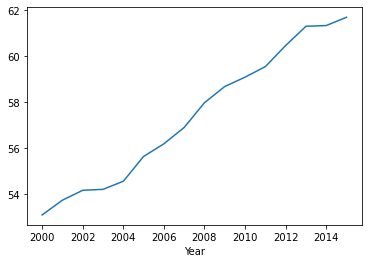

In [9]:
#Basic Line Graph: Life Expectancy vs. Time by Region (switch df for desired region)
le_time = africa_0.groupby(['Year']).mean()['Life Expectancy']
le_time.plot(kind='line')
plt.show()

p-value: 8.468018498016822e-51
r-value: -0.5089650632982948


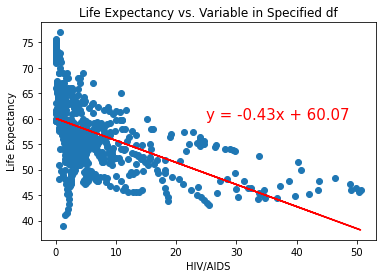

In [10]:
#Linear Regression/Basic Scatter Plot Code (switch df and x for desired outcome)
#Input Variable vs Life Expectancy
(slope, intercept, rvalue, pvalue, stderr) = linregress(africa_0['HIV/AIDS'], africa_0["Life Expectancy" ])
regress_values = africa_0["HIV/AIDS"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#Print r-value >>>>>>>>>>>>>> figure out print formatting
print(f'p-value: {pvalue}')
print(f'r-value: {rvalue}')

#Annotate LR, create labels, then print scatter plot w/ linear regress equation
plt.scatter(africa_0["HIV/AIDS"], africa_0["Life Expectancy"])
plt.plot(africa_0["HIV/AIDS"], regress_values, "r-")
plt.annotate(line_eq,(25,60),fontsize=15,color="red")
plt.xlabel("HIV/AIDS")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy vs. Variable in Specified df")
#plt.savefig("output_data/north_lat_vs_maxtemp.png")
plt.show()

In [11]:
immune_df.head()

,Country,Year,Region,Status,Life Expectancy,Population,Polio,Diphtheria,Hepatitis B
0,Afghanistan,2015,Eastern Mediterranean,Developing,65.0,33736494.0,6.0,65.0,65.0
1,Afghanistan,2014,Eastern Mediterranean,Developing,59.9,327582.0,58.0,62.0,62.0
2,Afghanistan,2013,Eastern Mediterranean,Developing,59.9,31731688.0,62.0,64.0,64.0
3,Afghanistan,2012,Eastern Mediterranean,Developing,59.5,3696958.0,67.0,67.0,67.0
4,Afghanistan,2011,Eastern Mediterranean,Developing,59.2,2978599.0,68.0,68.0,68.0


p-value: 9.056503318445971e-33
r-value: 0.29706889857266816


Text(50, 80, 'r = 0.29706889857266816')

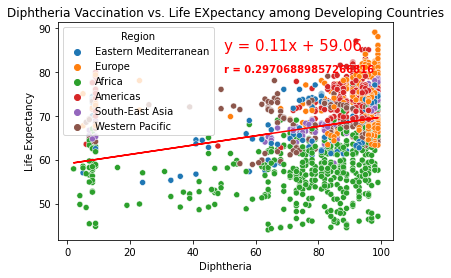

In [27]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(undev_immune["Diphtheria"], undev_immune['Life Expectancy'])
regress_values = undev_immune["Diphtheria"] * slope + intercept

print(f'p-value: {pvalue}')
print(f'r-value: {rvalue}')


sns.scatterplot(data=undev_immune, x="Diphtheria", y="Life Expectancy", hue='Region', legend = True)
plt.plot(undev_immune["Diphtheria"], regress_values, "r-")
plt.title("Diphtheria Vaccination vs. Life EXpectancy among Developing Countries")
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(50,85),fontsize=15,color="red")
r_eq = f"r = {rvalue}"
plt.annotate(r_eq, (50,80), color = "r", fontweight = "bold")


In [37]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(undev_dis["Diphtheria"], undev_dis['Life Expectancy'])
regress_values = undev_dis["Diphtheria"] * slope + intercept

print(f'p-value: {pvalue}')
print(f'r-value: {rvalue}')


sns.scatterplot(data=undev_dis, x="Diphtheria", y="Life Expectancy", hue='Region', legend = True)
plt.plot(undev_dis["Diphtheria"], regress_values, "r-")
plt.title("DTP3 Vaccinations vs. Life EXpectancy among Developing Countries")
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(5, 40),fontsize=15,color="red")
r_eq = f"r = {rvalue}"
plt.annotate(r_eq, (5, 30), color = "r", fontweight = "bold")


KeyError: 'Diphtheria'

In [ ]:
#Plotly Scatter Plot (switch out df and x_axis for desired outcome)

#Adult Mortality vs. Life Expectancy

fig = px.scatter(mean_df, x="Adult Mortality", y="Life Expectancy", animation_frame="Year", animation_group="Country",
           size="Population", color="Region", hover_name="Country",
           log_x=False, size_max=55, range_x=[0,700], range_y=[25,90])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [44]:
#HIV/AIDS vs. Adult Mortality


fig = px.scatter(disease_df, x="HIV/AIDS", y="Life Expectancy", animation_frame="Year", animation_group="Country",
           size="Population", color="Region", hover_name="Country",
           log_x=True, size_max=55, range_x=[.05,50], range_y=[40,90])

fig["layout"].pop("updatemenus") # optional, drop animation buttons

fig.show()

In [46]:
#HIV/AIDS vs. Life Expectancy

fig = px.scatter(immune_df, x="Diphtheria", y="Life Expectancy", animation_frame="Year", animation_group="Country",
           size="Population", color="Region", hover_name="Country",
           log_x=False, size_max=55, range_x=[0,100], range_y=[25,90])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()